### Model Development ###

Up to this point our efforts have been focused on the selection of training pairs or correspondences. These pairs consist of locations of pixels that are in the shade, and associated pixel lists that *may* be the same surface type, but are out in the open. Using the spectral information of the pixels in the open, we develop a model aimed at learning the local radiance attenuation.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from hyperspectral import *
import pandas as pd
import numpy as np
import pickle

correspondences = pickle.load(open('data/training_correspondences.p', 'rb'))
hsi_import = np.load('data/hsi_data.npz')
hsi_data = hsi_import['hyperspectral_data']
wavelengths = hsi_import['wavelengths']

#### Compiling Observations and Targets ####

Given the correspondences determined in previous steps, we can build the data sets we wish to use in training our models. From the correspondence pairs we have our observations, the pixels in the shade, and a batch of candidate targets, pixels to believed to represent the same material in direct sunlight.  

We'll generate several variants of our 'target' variables from the candidates listed in our correspondences. To start we'll evaluate the minimum, mean, and maximum spectra.

In [10]:
hsi_data_matrix = multispectral_raster_to_matrix(hsi_data)
image_width = hsi_data.shape[1]

observation_indices = []
min_target_indices = []
max_target_indices = []

for pixel in correspondences:
    observation_indices.append(pixel[0] * image_width + pixel[1])
    open_norms = [ np.linalg.norm(get_spectrum(hsi_data, px)) for px in correspondences[pixel] ]
    min_norm_pixel = correspondences[pixel][np.argmin(open_norms)]
    max_norm_pixel = correspondences[pixel][np.argmax(open_norms)]
    min_target_indices.append(min_norm_pixel[0] * image_width + min_norm_pixel[1])
    max_target_indices.append(max_norm_pixel[0] * image_width + max_norm_pixel[1])

observation_matrix = hsi_data_matrix[observation_indices, :]
target_matrices = { 'min' : hsi_data_matrix[min_target_indices, :], 'max' : hsi_data_matrix[max_target_indices, :] }
target_matrices['mean'] = np.zeros_like(target_matrices['min'])

current_row = 0
for pixel in correspondences:
    open_norms = [ np.linalg.norm(get_spectrum(hsi_data, px)) for px in correspondences[pixel] ]
    target_matrices['mean'][current_row, :] = np.mean(open_norms, axis = 0)
    current_row += 1

#### Reduced Space Ridge Regression ####

As an initial example we evaluate the output of a kernel ridge regression model trained on a reduced dimensionality version of our data. 

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from pca import principal_components

number_dimensions = 8

pc = principal_components(hsi_data_matrix)
reduced_observation_matrix = pc.reduce_dimension(observation_matrix, number_dimensions)
reduced_target_matrices = {}
for label in target_matrices:
    reduced_target_matrices[label] = pc.reduce_dimension(target_matrices[label], number_dimensions)

In [29]:
parameters = { 'alpha': [ 0.1, 0.05, 0.01, 0.005 ], 'gamma': [ 1.0, 5.0, 10.0, 50.0  ], 'kernel' : ['linear', 'rbf'] }
model = GridSearchCV(KernelRidge(), parameters, scoring='neg_mean_squared_error', cv=10)

for label in reduced_target_matrices:
    model.fit(reduced_observation_matrix, reduced_target_matrices[label])
    print('Evaluating model using', label, 'candidate spectra...')
    print('CV Selected Parameters:', model.best_params_, '\n')

Evaluating model using min candidate spectra...
CV Selected Parameters: {'alpha': 0.1, 'gamma': 10.0, 'kernel': 'rbf'} 

Evaluating model using max candidate spectra...
CV Selected Parameters: {'alpha': 0.05, 'gamma': 50.0, 'kernel': 'rbf'} 

Evaluating model using mean candidate spectra...
CV Selected Parameters: {'alpha': 0.05, 'gamma': 5.0, 'kernel': 'rbf'} 



#### Min Spectra Model Plots ####

As a quick visual example we plot the spectra of several observations in the shade against their minimum-norm correspondence, as well as what the model trained on minimum-norm correspondences estimates the unobstructed radiance should be.

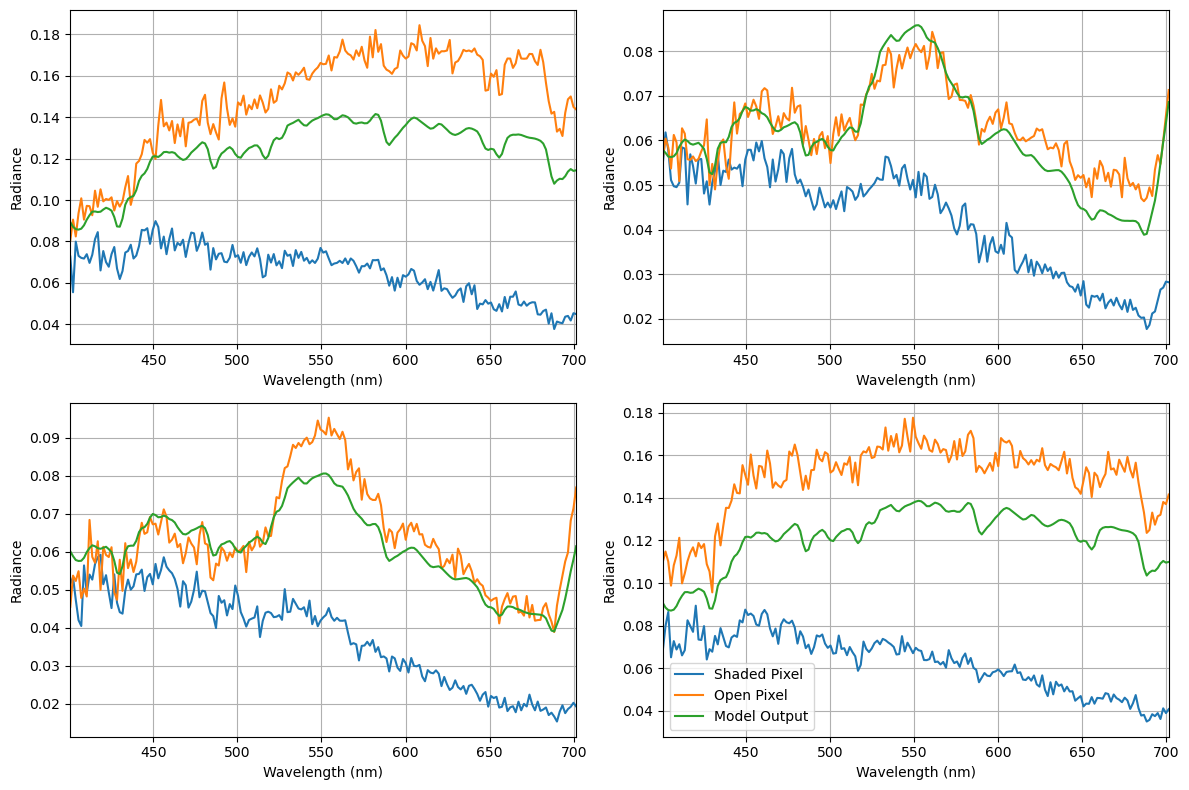

In [30]:
min_krr_model = KernelRidge(alpha=0.1, gamma=10.0, kernel='rbf')
min_krr_model.fit(reduced_observation_matrix, reduced_target_matrices['min'])

reduced_space_predictions = min_krr_model.predict(reduced_observation_matrix)
reconstructed_predictions = pc.reconstruct(reduced_space_predictions)

plt.figure(figsize=(12,8))
for plot in [ 221, 222, 223, 224 ]:
    
    sample_index = np.random.randint(0, len(observation_indices))
    spectra = [ 
        observation_matrix[sample_index, :], 
        target_matrices['min'][sample_index, :],
        reconstructed_predictions[sample_index, :] 
    ]

    plt.subplot(plot)
    if plot == 224:
        spectra_plot(wavelengths, np.array(spectra), legend_labels=['Shaded Pixel', 'Open Pixel', 'Model Output'])
    else : spectra_plot(wavelengths, np.array(spectra))

plt.tight_layout()
plt.show()